# Pima Indians Diabetes Classification using SVC

This project aims to show the importance of choosing cross-validation applied to SVMs

## 0) Imports & Config

In [5]:
# imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    GridSearchCV, KFold, StratifiedKFold, train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay, classification_report
)

# random state
RANDOM_STATE = 42

## 1) Load data & split

In [6]:
# https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download
df = pd.read_csv("diabetes.csv")

# separate features and target
X = df.drop("Outcome", axis=1).values
y = df["Outcome"].values

# labels
labels = ["non-diabetic", "diabetic"]

# train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Shapes:", "X_train", X_train.shape, "| X_test", X_test.shape)
print("Class distribution (train):", np.bincount(y_train))
print("Class distribution (test):", np.bincount(y_test))

# dataset size
print("Total samples:", len(df))


Shapes: X_train (614, 8) | X_test (154, 8)
Class distribution (train): [400 214]
Class distribution (test): [100  54]
Total samples: 768


## 2) Base pipeline (Impute → Scale → SVC)

In [7]:
# pipeline
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC())
])

## 3) Parameter grid (linear / rbf / poly / sigmoid)

In [9]:
# param grid
param_grid = [
    {"clf__kernel": ["linear"], "clf__C": [0.01, 0.1, 1, 10, 100]},
    {"clf__kernel": ["rbf"], "clf__C": [0.01, 0.1, 1, 10, 100], "clf__gamma": ["scale", 0.01, 0.001]},
    {"clf__kernel": ["poly", "sigmoid"], "clf__C": [0.01, 0.1, 1, 10, 100]},
]

## 4) GridSearchCV (10-fold, stratified)


Best kernel (Grid Search): linear
Best C: 0.1
Test Accuracy (best kernel): 72.08%


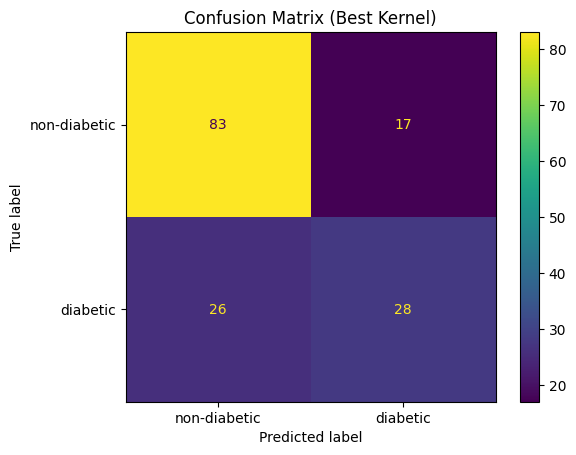

In [8]:
# KFold with 10 splits
cv10 = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# GridSearchCV parameters
gs_k10 = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv10,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

# model training
gs_k10.fit(X_train, y_train)

# extracting information about the best model
best_kernel = gs_k10.best_params_['clf__kernel']
best_c = gs_k10.best_params_['clf__C']
y_pred = gs_k10.predict(X_test)

# accuracy
acc = accuracy_score(y_test, y_pred)

# displaying results
print("Best kernel (Grid Search):", best_kernel)
print("Best C:", best_c)
print(f"Test Accuracy (best kernel): {acc * 100:.2f}%")

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title("Confusion Matrix (Best Kernel)")
plt.show()

## 5) GridSearchCV (3-fold, stratified — quick check)

Best kernel (Grid Search): rbf
Best C: 10
Best Gamma: 0.01
Test Accuracy (best kernel): 75.32%


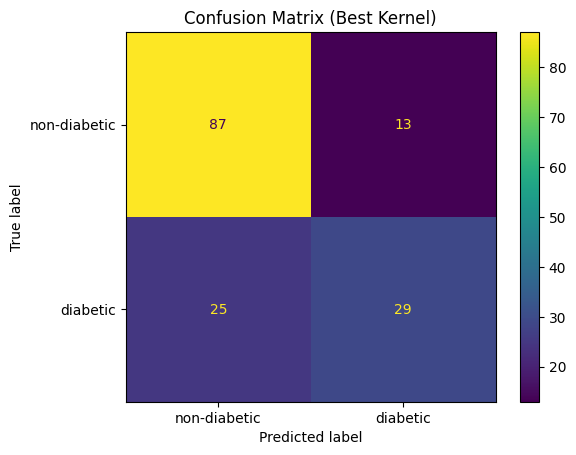

In [10]:
# StratifiedKFold with 3 splits
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# GridSearchCV parameters
gs_s3 = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv3,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

# model training
gs_s3.fit(X_train, y_train)

# extracting the best parameters
best_kernel = gs_s3.best_params_['clf__kernel']
best_c = gs_s3.best_params_['clf__C']
best_gamma = gs_s3.best_params_['clf__gamma']
y_pred = gs_s3.predict(X_test)

# accuracy
acc = accuracy_score(y_test, y_pred)

# Displaying information
print("Best kernel (Grid Search):", best_kernel)
print("Best C:", best_c)
print("Best Gamma:", best_gamma)
print(f"Test Accuracy (best kernel): {acc * 100:.2f}%")

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title("Confusion Matrix (Best Kernel)")
plt.show()


## 6) Hold Out


Hold-out [rbf]
Accuracy: 75.32%  |  F1: 0.6042  |  Recall+: 0.5370

Classification report:
              precision    recall  f1-score   support

non-diabetic     0.7768    0.8700    0.8208       100
    diabetic     0.6905    0.5370    0.6042        54

    accuracy                         0.7532       154
   macro avg     0.7336    0.7035    0.7125       154
weighted avg     0.7465    0.7532    0.7448       154



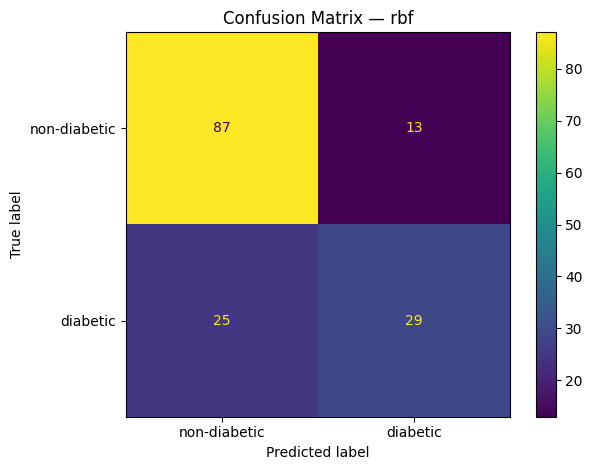

In [11]:
model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=10, gamma=0.01))
])

model.fit(X_train, y_train)

# previsions on test set
y_pred = model.predict(X_test)

# metrics
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

# results
print(f"\nHold-out [rbf]")
print(f"Accuracy: {acc*100:.2f}%  |  F1: {f1:.4f}  |  Recall+: {rec:.4f}")
print("\nClassification report:")
print(classification_report (y_test, y_pred, target_names=labels, digits=4))

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title(f"Confusion Matrix — {best_kernel}")
plt.tight_layout()
plt.show()

## 7) Classification report → DataFrame (pretty)#### Classification Report

In [15]:
classes = np.unique(y_test)
name_map = {0: "non diabétic", 1: "diabetic"}
target_names = [name_map.get(int(c), str(c)) for c in classes]
rep = classification_report(
   y_test, y_pred,
   labels=classes,
   target_names=target_names,
   output_dict=True,
   zero_division=0
)
df = pd.DataFrame(rep).transpose()
order = target_names + ["accuracy", "macro avg", "weighted avg"]
df = df.loc[order, ["precision", "recall", "f1-score", "support"]]
df = df.round({"precision":4, "recall":4, "f1-score":4})
df["support"] = df["support"].astype(int)
display(df)

,precision,recall,f1-score,support
non diabétic,0.7768,0.8700,0.8208,100
diabetic,0.6905,0.5370,0.6042,54
accuracy,0.7532,0.7532,0.7532,0
macro avg,0.7336,0.7035,0.7125,154
weighted avg,0.7465,0.7532,0.7448,154
